In [62]:
import configparser
import json
import math
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ximc import XimcRedmine

# Курс валюты, необходим для сведения финальных рублевых цифр
USD_CB = 75.1
# Интервалы, в которые будет собираться статистика
QUARTERS = {"2018 Q1": ("2018-01-01", "2018-03-31"),
            "2018 Q2": ("2018-04-01", "2018-06-30"),
            "2018 Q3": ("2018-07-01", "2018-09-30"),
            "2018 Q4": ("2018-10-01", "2018-12-31"),
            "2019 Q1": ("2019-01-01", "2019-03-31"),
            "2019 Q2": ("2019-04-01", "2019-06-30"),
            "2019 Q3": ("2019-07-01", "2019-09-30"),
            "2019 Q4": ("2019-10-01", "2019-12-31"),
            "2020 Q1": ("2020-01-01", "2020-03-31"),
            "2020 Q2": ("2020-04-01", "2020-06-30"),
            "2020 Q3": ("2020-07-01", "2020-09-30"),
            "2020 Q4": ("2020-10-01", "2020-12-31"),
            "2021 Q1": ("2021-01-01", "2021-03-31"),
            "2021 Q2": ("2021-04-01", "2021-06-30"),
            "2021 Q3": ("2021-07-01", "2021-09-30"),
            "2021 Q4": ("2021-10-01", "2021-12-31")}

# Проекты, с которыми будем работать, делим их на 4 группы: Malt, EZ, Raw, Zap.
# Причем группа Raw содержит только платежи, но не сожержит связанных с ними проектов
MALT_PROJ_LIST = ["ADC", "Buk2-Burg2", "DAC", "DPLL", "Freon", "Magma", "NPU", "Open", "PIC", "Shared", "MALT2011-20"]
MALT_PAYMENT_LIST = ["ADC-payments", "Burg2-payments", "DAC-payments", "DPLL-payments", "Freon-payments",
                     "Magma-payments", "NPU-payments", "Open-payments", "PIC-payments", "Shared-payments",
                     "allpayments"]
EZ_PROJ_LIST = ["AI", "Bombardie", "Dauria", "EyePoint", "Fazli", "General", "Meridian", "Printeltech", "RAC", "TP",
                "TVI", "UltraRay", "XBB", "ximc"]
EZ_PAYMENT_LIST = ["EN-Payments", "Bom-Payments", "DA-Payments", "EP-Payments", "FAZ-Payments", "Gen-Payments",
                   "M-Payments", "PET-Payments", "RAC-Payments", "TP-Payments", "TVI-Payments", "UR-Payments",
                   "XBB-Payments", "XI-Payments"]
RAW_PAYMENT_LIST = ["Dividends", "Payments"]
ZAP_PROJ_LIST = ["Z30", "ZEL", "ZRocket"]
ZAP_PAYMENT_LIST = ["Z30-Payments", "ZEL-Payments", "ZRocket"]
C = 105  # постоянная

# Проходим авторизацию в Redmine для дальнейшего сбора статистики с сайта
config = configparser.ConfigParser()
config.read("config.ini")
user_name = config.get("MAIN", "login")
password = config.get("MAIN", "password")

try:
    ximc_user = XimcRedmine(user_name, password)
    ximc_user.auth()
except Exception:
    print("User authorization failed")
    sys.exit(0)

In [47]:
def read_results_from_json_file(file_name: str) -> dict:
    """
    Функция читает JSON-файл и возвращает данные из файла.
    :param file_name: имя файла.
    :return: прочтенные данные.
    """

    with open(file_name, "r", encoding="utf-8") as file:
        return json.load(file)

        
def save_results_to_json_file(file_name: str, data: dict):
    """
    Функция сохраняет данные в JSON-файл.
    :param file_name: имя файла, куда сохранить данные.
    :param data: данные для сохранения.
    """

    with open(file_name, "w", encoding="utf-8") as file:
        json.dump(data, file)
        

def get_incomes_or_expenditures(rub: bool, income: bool, project_name: str, start_date: str, stop_date: str) -> float:
    """
    Функция возвращает рублевые или долларовые доходы или расходы за заданный период времени.
    :param rub: если значение True, то будут возвращены рублевые доходы или расходы, иначе - долларовые;
    :param income: если значение True, то будут возвращены доходы, иначе - расходы;
    :param project_name: название проекта;
    :param start_date: дата начала;
    :param stop_date: дата конца.
    :return: рублевые или долларовые доходы или расходы.
    """

    # Задаем фильтры
    ximc_user.clear_filters()
    ximc_user.add_filter("Проект", "соответствует", project_name)
    ximc_user.add_filter("Статус", "соответствует", "Closed")
    ximc_user.add_filter("Трекер", "соответствует", "Payment")
    ximc_user.add_filter("Срок завершения", "между", start_date, stop_date)
    if rub:
        ximc_user.add_filter("Тема", "не содержит", "валют")
    else:
        ximc_user.add_filter("Тема", "содержит", "валют")
    if income:
        ximc_user.add_filter("Payment category", "соответствует", "Income")
    else:
        ximc_user.add_filter("Payment category", "не соответствует", "Income")
    # Запрашиваем необходимые итоговые параметры
    total = 0
    totals = ximc_user.get_totals("Payment cash", "Payment cashless")
    if totals["Payment cash"] is not None:
        total += totals["Payment cash"]
    if totals["Payment cashless"] is not None:
        total += totals["Payment cashless"]
    return total

In [48]:
# Сохранение в файл рублевые и долларовые доходы и расходы с 2018 по 2021
result = {}
# Общий перечень проектов, включающий все, по нему можно общие сверять цифры с треккером
payment_list = MALT_PAYMENT_LIST + EZ_PAYMENT_LIST + RAW_PAYMENT_LIST + ZAP_PAYMENT_LIST
print("\nОбщие доходы/расходы по всем проектам за 2018-2021 по кварталам:")
for project_name in payment_list:
    result[project_name] = {}
    print(project_name)
    for quarter_name, quarter_period in QUARTERS.items():
        start_date, stop_date = quarter_period
        # Рублевые доходы
        income_rub = get_incomes_or_expenditures(True, True, project_name, start_date, stop_date)
        # Рублевые расходы
        expenditure_rub = get_incomes_or_expenditures(True, False, project_name, start_date, stop_date)
        # Долларовые доходы
        income_usd = get_incomes_or_expenditures(False, True, project_name, start_date, stop_date)
        # Долларовые расходы
        expenditure_usd = get_incomes_or_expenditures(False, False, project_name, start_date, stop_date)
        print(f"{quarter_name} ({quarter_period[0]} - {quarter_period[1]}):", income_rub, expenditure_rub, income_usd, expenditure_usd)
        result[project_name][quarter_name] = {"INCOME_RUB": income_rub,
                                              "EXPENDITURE_RUB": expenditure_rub,
                                              "INCOME_USD": income_usd,
                                              "EXPENDITURE_USD": expenditure_usd}
# Сохраняем данные
file_name = f"finances {datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.json"
save_results_to_json_file(file_name, result)
print(f"Данные были сохранены в файл {file_name}")


Общие доходы/расходы по всем проектам за 2018-2021 по кварталам:
ADC-payments
2018 Q1 (2018-01-01 - 2018-03-31): 0 0 0 0
2018 Q2 (2018-04-01 - 2018-06-30): 0 0 0 0
2018 Q3 (2018-07-01 - 2018-09-30): 0 0 0 0
2018 Q4 (2018-10-01 - 2018-12-31): 0 0 0 0
2019 Q1 (2019-01-01 - 2019-03-31): 0 0 0 0
2019 Q2 (2019-04-01 - 2019-06-30): 0 0 0 0
2019 Q3 (2019-07-01 - 2019-09-30): 0 0 0 0
2019 Q4 (2019-10-01 - 2019-12-31): 0 0 0 0
2020 Q1 (2020-01-01 - 2020-03-31): 0 0 0 0
2020 Q2 (2020-04-01 - 2020-06-30): 0 0 0 0
2020 Q3 (2020-07-01 - 2020-09-30): 0 0 0 0
2020 Q4 (2020-10-01 - 2020-12-31): 0 515955.0 0 0
2021 Q1 (2021-01-01 - 2021-03-31): 0 2277531.0 0 0
2021 Q2 (2021-04-01 - 2021-06-30): 0 1691471.0 0 0
2021 Q3 (2021-07-01 - 2021-09-30): 0 2252416.0 0 0
2021 Q4 (2021-10-01 - 2021-12-31): 0 3023513.0 0 0
Burg2-payments
2018 Q1 (2018-01-01 - 2018-03-31): 0 0 0 0
2018 Q2 (2018-04-01 - 2018-06-30): 0 0 0 0
2018 Q3 (2018-07-01 - 2018-09-30): 0 0 0 0
2018 Q4 (2018-10-01 - 2018-12-31): 0 0 0 0
2019 Q1

2021 Q1 (2021-01-01 - 2021-03-31): 6900000.0 4664096.0 0 0
2021 Q2 (2021-04-01 - 2021-06-30): 0 137330.0 0 0
2021 Q3 (2021-07-01 - 2021-09-30): 0 15025.0 0 0
2021 Q4 (2021-10-01 - 2021-12-31): 16342614.0 0 0 0
EN-Payments
2018 Q1 (2018-01-01 - 2018-03-31): 0 0 0 0
2018 Q2 (2018-04-01 - 2018-06-30): 0 0 0 0
2018 Q3 (2018-07-01 - 2018-09-30): 0 0 0 0
2018 Q4 (2018-10-01 - 2018-12-31): 0 0 0 0
2019 Q1 (2019-01-01 - 2019-03-31): 0 0 0 0
2019 Q2 (2019-04-01 - 2019-06-30): 0 0 0 0
2019 Q3 (2019-07-01 - 2019-09-30): 0 0 0 0
2019 Q4 (2019-10-01 - 2019-12-31): 0 0 0 0
2020 Q1 (2020-01-01 - 2020-03-31): 0 0 0 0
2020 Q2 (2020-04-01 - 2020-06-30): 0 0 0 0
2020 Q3 (2020-07-01 - 2020-09-30): 0 0 0 0
2020 Q4 (2020-10-01 - 2020-12-31): 782729.0 557339.0 0 0
2021 Q1 (2021-01-01 - 2021-03-31): 3262297.0 2416457.0 0 0
2021 Q2 (2021-04-01 - 2021-06-30): 3792225.0 2867160.0 0 0
2021 Q3 (2021-07-01 - 2021-09-30): 4880814.0 3620262.0 0 0
2021 Q4 (2021-10-01 - 2021-12-31): 5964555.0 4516512.0 0 0
Bom-Payments

2021 Q3 (2021-07-01 - 2021-09-30): 0 0 0 0
2021 Q4 (2021-10-01 - 2021-12-31): 0 0 0 0
TVI-Payments
2018 Q1 (2018-01-01 - 2018-03-31): 0 23741.0 0 0
2018 Q2 (2018-04-01 - 2018-06-30): 225000.0 79152.0 0 0
2018 Q3 (2018-07-01 - 2018-09-30): 225000.0 42433.0 0 0
2018 Q4 (2018-10-01 - 2018-12-31): 0 5600.0 0 0
2019 Q1 (2019-01-01 - 2019-03-31): 0 4179.0 0 0
2019 Q2 (2019-04-01 - 2019-06-30): 0 0 0 0
2019 Q3 (2019-07-01 - 2019-09-30): 0 0 0 0
2019 Q4 (2019-10-01 - 2019-12-31): 0 0 0 0
2020 Q1 (2020-01-01 - 2020-03-31): 0 0 0 0
2020 Q2 (2020-04-01 - 2020-06-30): 0 0 0 0
2020 Q3 (2020-07-01 - 2020-09-30): 0 0 0 0
2020 Q4 (2020-10-01 - 2020-12-31): 0 0 0 0
2021 Q1 (2021-01-01 - 2021-03-31): 0 0 0 0
2021 Q2 (2021-04-01 - 2021-06-30): 0 0 0 0
2021 Q3 (2021-07-01 - 2021-09-30): 0 0 0 0
2021 Q4 (2021-10-01 - 2021-12-31): 0 0 0 0
UR-Payments
2018 Q1 (2018-01-01 - 2018-03-31): 1764.0 1185612.0 0 0
2018 Q2 (2018-04-01 - 2018-06-30): 13018256.0 2445249.0 0 0
2018 Q3 (2018-07-01 - 2018-09-30): 2992776.

In [49]:
# Чтение из файла рублевых и долларовых доходов и расходов
file_name = "finances 2022-03-23 16-33-57.json"  # нужно указать имя файла с данными
data = read_results_from_json_file(file_name)

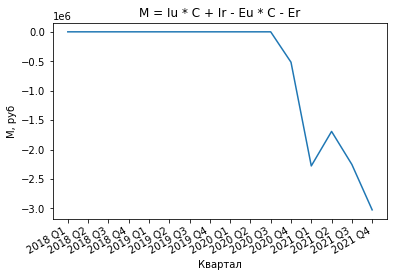

In [50]:
# Постоение графика для заданного проекта
project_name = "ADC-payments"  # нужно указать имя проекта

# Готовим данные для графика
data_for_project = data[project_name]
x_values = sorted(QUARTERS.keys())
y_values = []
for quarter in x_values:
    income_rub = data_for_project[quarter]["INCOME_RUB"]
    expenditure_rub = data_for_project[quarter]["EXPENDITURE_RUB"]
    income_usd = data_for_project[quarter]["INCOME_USD"]
    expenditure_usd = data_for_project[quarter]["EXPENDITURE_USD"]
    y_values.append(C * (income_usd - expenditure_usd) + income_rub - expenditure_rub)

# Потом рисуем
fig, ax = plt.subplots(1, 1)
ax.plot(y_values)
ax.set_title("M = Iu * C + Ir - Eu * C - Er")
ax.set_xlabel("Квартал")
ax.set_ylabel("M, руб")
ax.set_xticks(range(len(x_values)))
ax.set_xticklabels(x_values)
fig.autofmt_xdate()

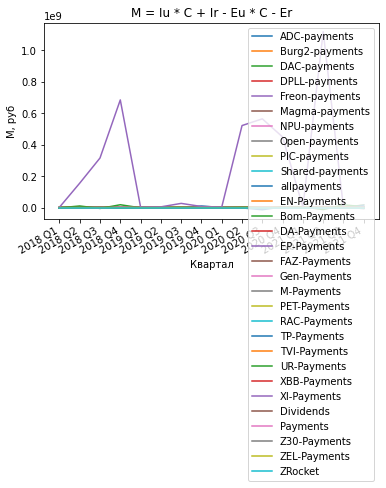

In [51]:
# Постоение графиков для всех проектов на одном рисунке
fig, ax = plt.subplots(1, 1)
for project_name in data:
    # Готовим данные для графика
    data_for_project = data[project_name]
    x_values = sorted(QUARTERS.keys())
    y_values = []
    for quarter in x_values:
        income_rub = data_for_project[quarter]["INCOME_RUB"]
        expenditure_rub = data_for_project[quarter]["EXPENDITURE_RUB"]
        income_usd = data_for_project[quarter]["INCOME_USD"]
        expenditure_usd = data_for_project[quarter]["EXPENDITURE_USD"]
        y_values.append(C * (income_usd - expenditure_usd) + income_rub - expenditure_rub)
    # Потом рисуем
    ax.plot(y_values, label=project_name)
ax.set_title("M = Iu * C + Ir - Eu * C - Er")
ax.set_xlabel("Квартал")
ax.set_ylabel("M, руб")
ax.set_xticks(range(len(x_values)))
ax.set_xticklabels(x_values)
ax.legend()
fig.autofmt_xdate()

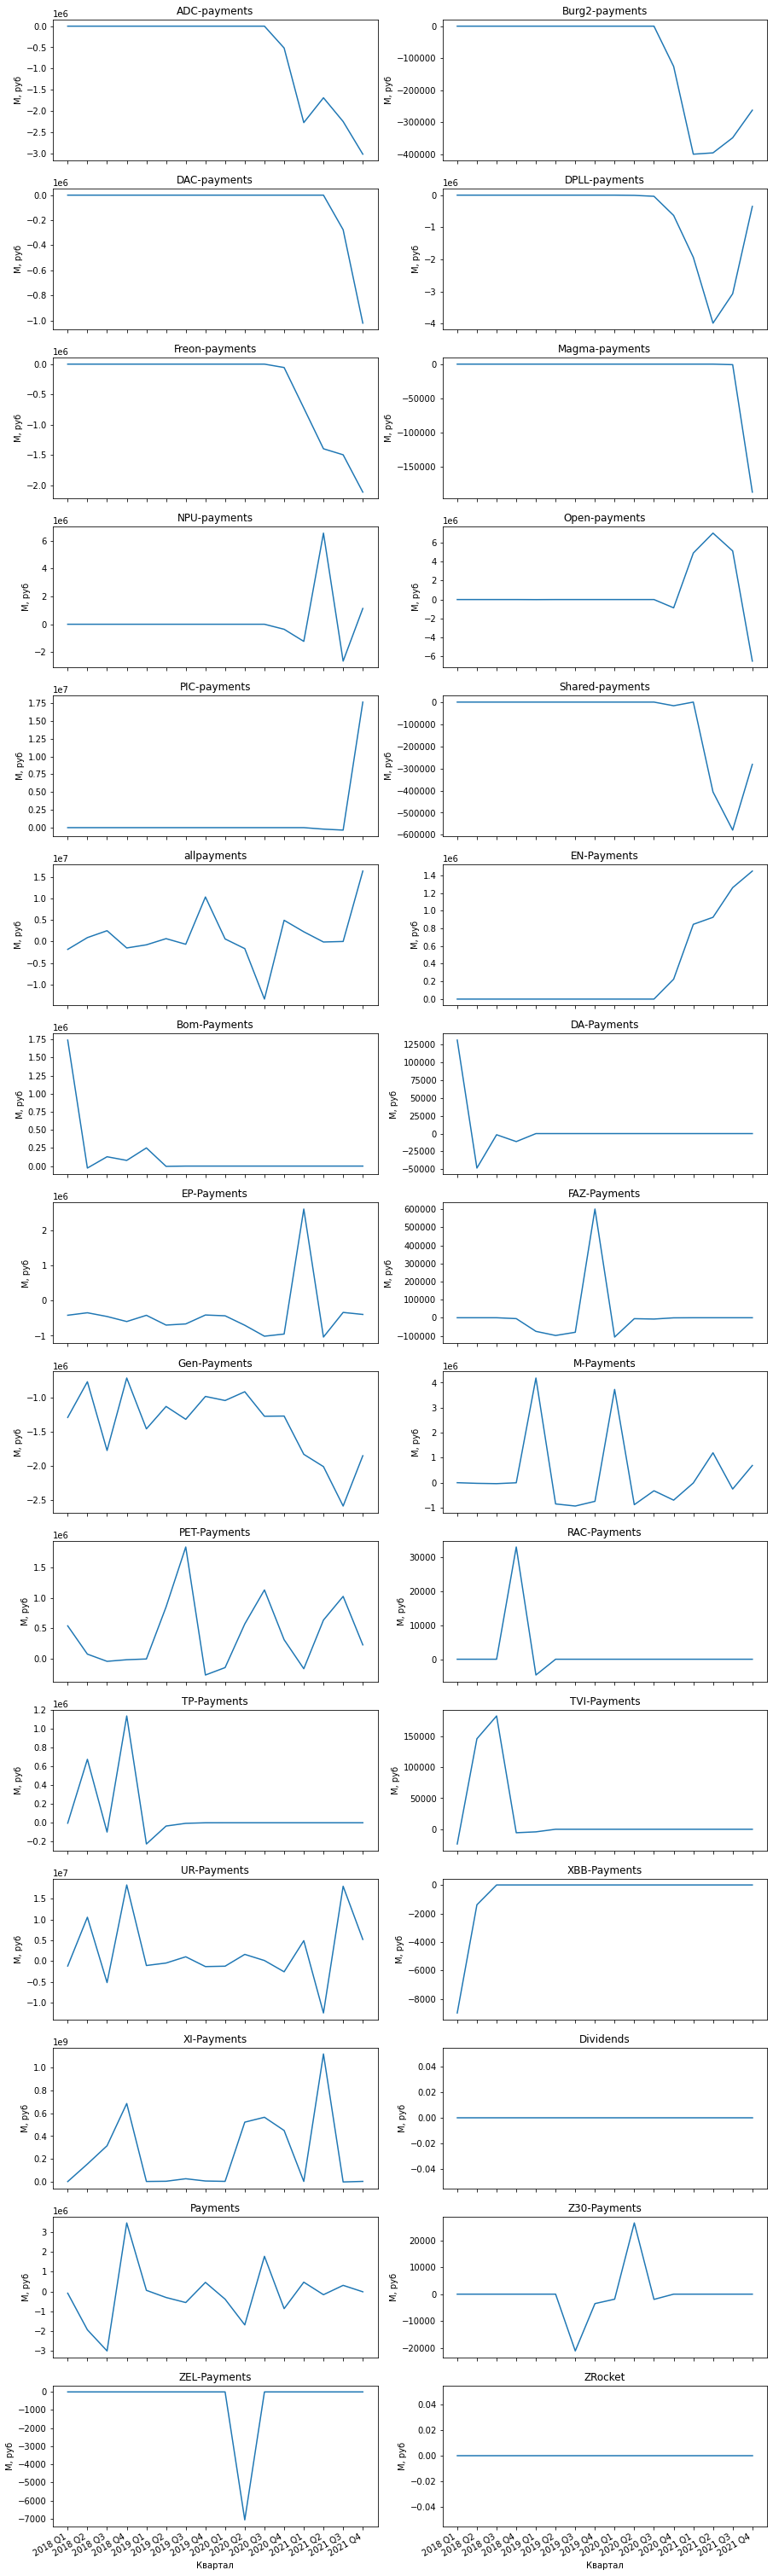

In [61]:
# Постоение графиков для всех проектов
n = math.ceil(len(data) / 2)
fig, axs = plt.subplots(n, 2, figsize=(15, 60))
for index, project_name in enumerate(data):
    # Готовим данные для графика
    data_for_project = data[project_name]
    x_values = sorted(QUARTERS.keys())
    y_values = []
    for quarter in x_values:
        income_rub = data_for_project[quarter]["INCOME_RUB"]
        expenditure_rub = data_for_project[quarter]["EXPENDITURE_RUB"]
        income_usd = data_for_project[quarter]["INCOME_USD"]
        expenditure_usd = data_for_project[quarter]["EXPENDITURE_USD"]
        y_values.append(C * (income_usd - expenditure_usd) + income_rub - expenditure_rub)
    # Потом рисуем
    axs[index // 2, index % 2].plot(y_values)
    axs[index // 2, index % 2].set_title(project_name)
    axs[index // 2, index % 2].set_xlabel("Квартал")
    axs[index // 2, index % 2].set_ylabel("M, руб")
    axs[index // 2, index % 2].set_xticks(range(len(x_values)))
    axs[index // 2, index % 2].set_xticklabels(x_values)
fig.autofmt_xdate()